In [1]:
import numpy as np
import pyart
import time
import os
import matplotlib.pyplot as plt

from radar_grid import (
    compute_grid_geometry,
    save_geometry,
    load_geometry,
    apply_geometry,
    apply_geometry_multi,
    get_gate_coordinates,
    get_field_data,
    get_radar_info,
    get_available_fields,
    plot_grid_slice,
    plot_grid_multi_level,
    plot_all_fields,
    plot_vertical_cross_section,
    GateFilter,
    create_mask_from_filter,
    constant_elevation_ppi,
    column_max,
    column_min,
    get_elevation_from_z_level,
)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
geometry_dir = '/workspaces/radar-processor/output/geometry/'
os.listdir(geometry_dir)

['RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz',
 'RMA1_0315_01_RES1500_TOA12000_FAC025_MR300_geometry.npz',
 'RMA1_0315_01_geometry.npz',
 'RMA1_0315_01_RES1500_TOA12000_FAC022_MR500_geometry.npz',
 'RMA1_0315_01_RES1200_TOA12000_FAC022_MR200_geometry.npz']

## Interpolation with loaded geometry

In [3]:
print("=" * 60)
print("RADAR_GRID MODULE - INTERPOLATION")
print("=" * 60)

# Load radar
file = '/workspaces/radar-processor/data/netcdf/RMA1_0315_01_20251208T191648Z.nc'
radar = pyart.io.read(file)

# 1. Radar info
print("\n1. RADAR INFO")
print("-" * 40)
info = get_radar_info(radar)
for k, v in info.items():
    print(f"   {k}: {v}")

# 2. Load pre-computed geometry
print("\n2. LOAD GEOMETRY")

print("-" * 40)
geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz')
print(geometry)

# 3. Single field interpolation with timing
print("\n3. SINGLE FIELD INTERPOLATION")
print("-" * 40)
dbzh_data = get_field_data(radar, 'DBZH')
start = time.time()
grid_dbzh = apply_geometry(geometry, dbzh_data)
elapsed = time.time() - start
print(f"   DBZH interpolation: {elapsed:.2f} seconds")
print(f"   Shape: {grid_dbzh.shape}")
print(f"   Range: [{np.nanmin(grid_dbzh):.2f}, {np.nanmax(grid_dbzh):.2f}] dBZ")
print(f"   Valid points: {np.sum(~np.isnan(grid_dbzh)):,} / {grid_dbzh.size:,}")

# 4. Multi-field interpolation
print("\n4. MULTI-FIELD INTERPOLATION")
print("-" * 40)
fields = {}
for name in get_available_fields(radar):
    data = get_field_data(radar, name)
    fields[name] = data
    

start = time.time()
grids = apply_geometry_multi(geometry, fields)
elapsed = time.time() - start
print(f"   {len(fields)} fields interpolated in {elapsed:.2f} seconds")
for name, grid in grids.items():
    print(f"   {name}: [{np.nanmin(grid):.2f}, {np.nanmax(grid):.2f}]")


RADAR_GRID MODULE - INTERPOLATION

1. RADAR INFO
----------------------------------------
   radar_name: RMA1
   strategy: 0315
   volume_nr: 01
   nrays: 5400
   ngates: 652
   nsweeps: 15
   total_gates: 3520800
   fields: ['KDP', 'DBZH', 'DBZV', 'PHIDP', 'RHOHV', 'ZDR']
   range_min: 2100.0
   range_max: 236460.0
   latitude: -31.44133
   longitude: -64.19192
   altitude: 484.0

2. LOAD GEOMETRY
----------------------------------------
GridGeometry(
  grid_shape=(np.int64(9), np.int64(315), np.int64(315)),
  grid_limits=((np.float64(0.0), np.float64(12000.0)), (np.int64(-236460), np.int64(236460)), (np.int64(-236460), np.int64(236460))),
  toa=12000.0m,
  radar_altitude=0.0m,
  n_pairs=25,343,066,
  avg_neighbors=28.4,
  memory=206.3 MB
)

3. SINGLE FIELD INTERPOLATION
----------------------------------------
   DBZH interpolation: 3.80 seconds
   Shape: (9, 315, 315)
   Range: [-18.90, 44.91] dBZ
   Valid points: 73,788 / 893,025

4. MULTI-FIELD INTERPOLATION
----------------------

## Visualization of interpolated data

In [4]:
# Load data
file = '/workspaces/radar-processor/data/netcdf/RMA1_0315_01_20251208T191648Z.nc'
radar = pyart.io.read(file)
geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz')

# Interpolate all fields
fields = {}
field_masks = {}
for name in get_available_fields(radar):
    # data, mask = get_field_data(radar, name)
    data = get_field_data(radar, name)
    fields[name] = data
    # field_masks[name] = mask

grids = apply_geometry_multi(geometry, fields, additional_filters=None)

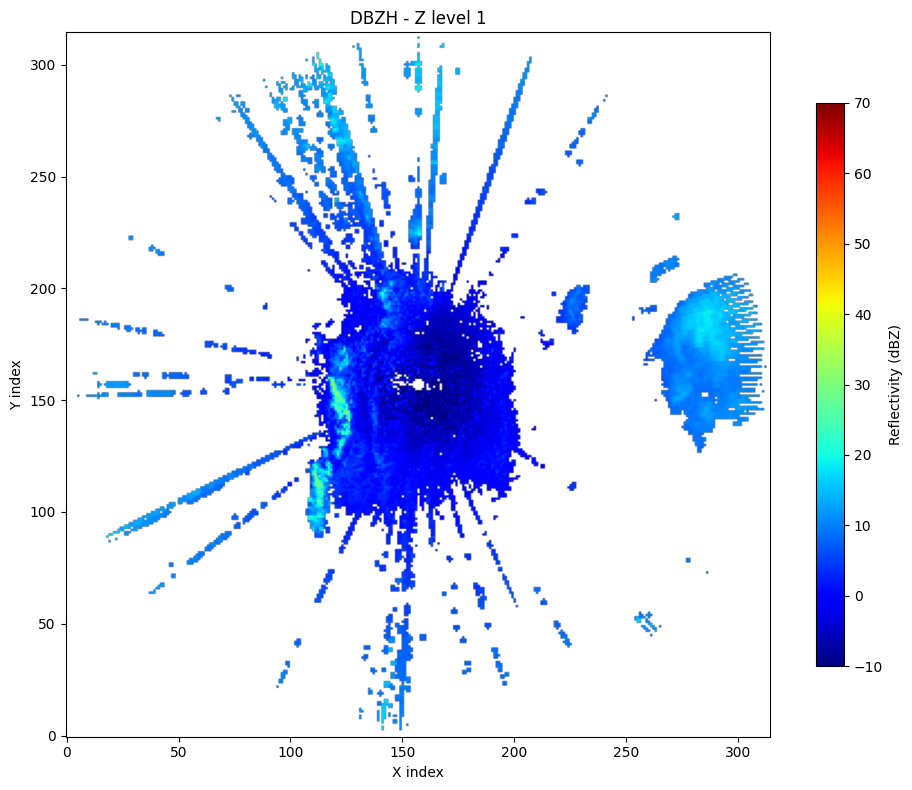

In [5]:
plot_grid_slice(grids['DBZH'], z_index=1, field_name='DBZH')

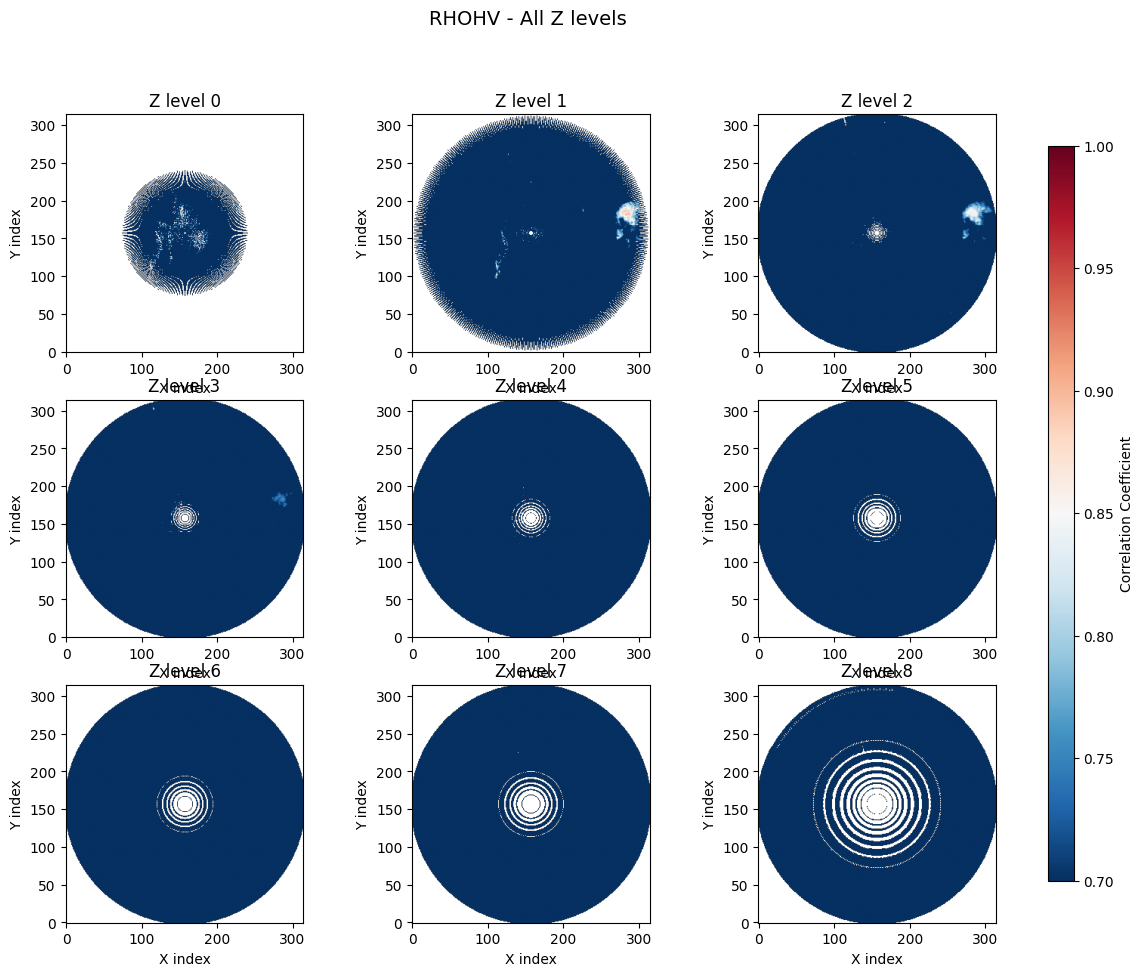

In [6]:
plot_grid_multi_level(grids['RHOHV'], field_name='RHOHV', vmin=0.7, vmax=1.0)

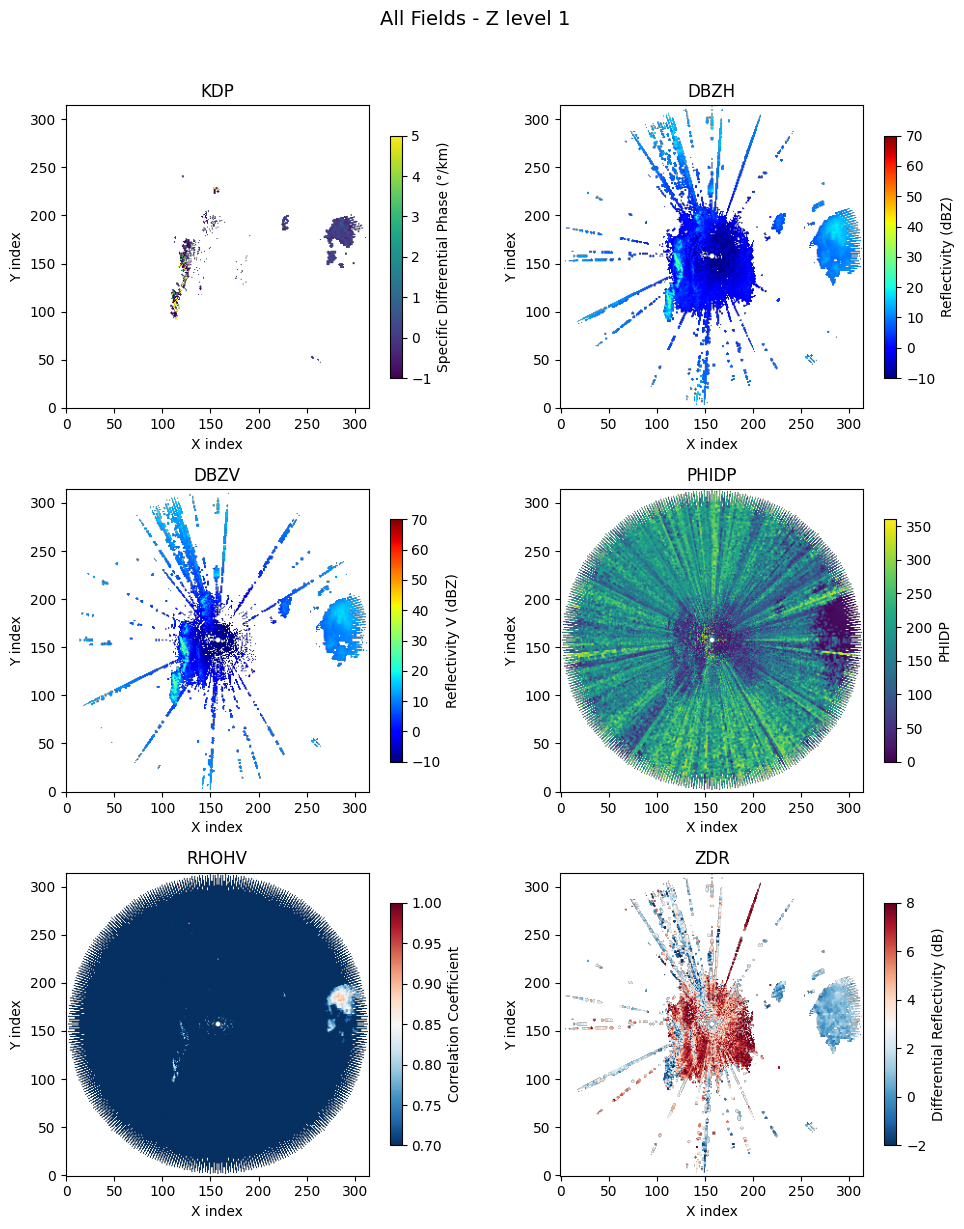

In [7]:
plot_all_fields(grids, z_index=1)

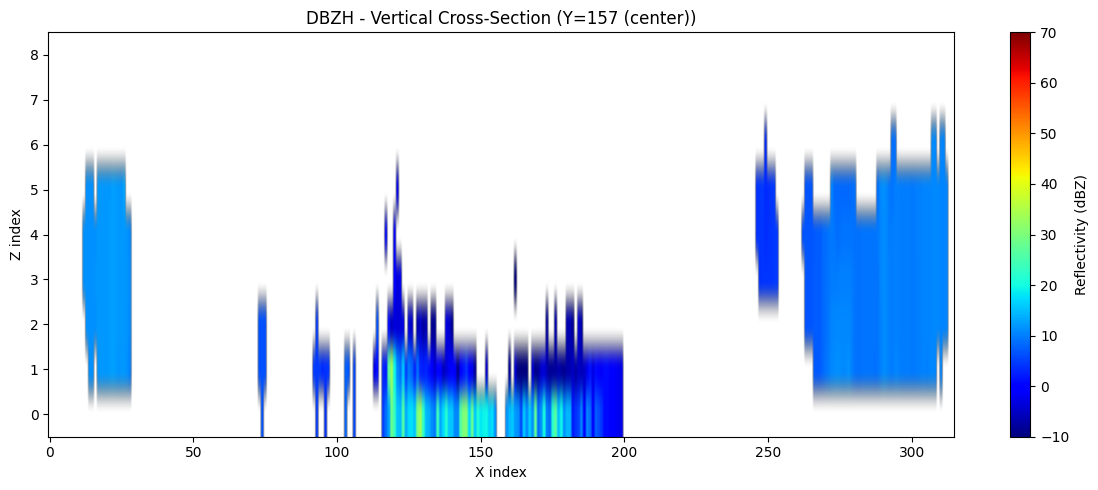

In [8]:
plot_vertical_cross_section(grids['DBZH'], field_name='DBZH')

## Filters

=== Without filter ===
Valid grid points: 73,788
DBZH range: [-18.90, 44.91]

=== With filter ===
GateFilter Summary:
  Total gates: 3,520,800
  Excluded: 3,286,080 (93.3%)
  Included: 234,720 (6.7%)
  Filters applied (1):
    - elevation angle > 0.65°

Valid grid points: 47,668
DBZH range: [-7.67, 44.91]

=== Visual comparison ===


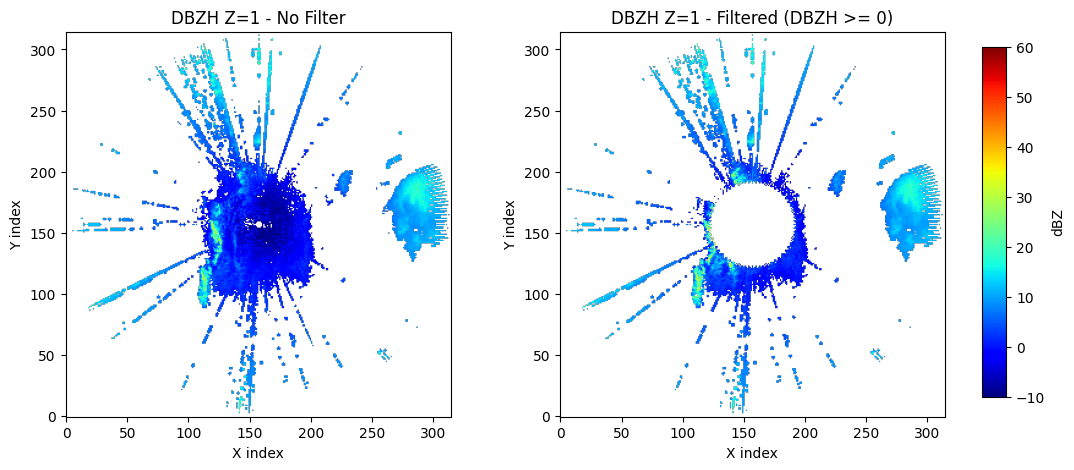

In [4]:
# Load data
# file = '/workspaces/radar-processor/data/netcdf/RMA3_0315_01_20251215T215802Z.nc'
# file = '/workspaces/radar-processor/data/netcdf/RMA3_0315_01_20251230T112500Z.nc'
file = '/workspaces/radar-processor/data/netcdf/RMA1_0315_01_20251208T191648Z.nc'
radar = pyart.io.read(file)
# geometry = load_geometry(geometry_dir + '/RMA1_0315_01_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1200_TOA12000_FAC022_MR200_geometry.npz')
geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz')

# --- Without filter ---
print("=== Without filter ===")
dbzh_data = get_field_data(radar, 'DBZH')
grid_no_filter = apply_geometry(geometry, dbzh_data)
print(f"Valid grid points: {np.sum(~np.isnan(grid_no_filter)):,}")
print(f"DBZH range: [{np.nanmin(grid_no_filter):.2f}, {np.nanmax(grid_no_filter):.2f}]")

# --- With filter ---
print("\n=== With filter ===")

# Create filter
gf = GateFilter(radar)
gf.exclude_above_elevation_angle(max_elev=0.65)
# # Create filter
# gf = GateFilter(radar)
# gf.exclude_below('DBZH', 0)       # Exclude reflectivity < 0 dBZ
# gf.exclude_below('RHOHV', 0.8) if 'RHOHV' in radar.fields else None  # Exclude low correlation
# gf.exclude_all_invalid('DBZH')    # Exclude NaN/Inf/masked

# # Method chaining for concise filter creation
# gf = (GateFilter(radar)
#       .exclude_below('DBZH', 5)
#       .exclude_above('DBZH', 60)
#       .exclude_above_range(200000)
#       .exclude_below_altitude(500))

# # Custom filter: exclude bottom 5th percentile
# gf = GateFilter(radar)
# gf.exclude_by_function(
#     'DBZH',
#     lambda x: x < np.percentile(x[(~np.isnan(x))&(~np.isinf(x))], 30),
#     description="bottom 5th percentile"
# )

print(gf.summary())

# Apply filter
# dbzh_data, combined_mask = create_mask_from_filter(radar, 'DBZH', gf)
grid_filtered = apply_geometry(geometry, dbzh_data, additional_filters=[gf])
print(f"\nValid grid points: {np.sum(~np.isnan(grid_filtered)):,}")
print(f"DBZH range: [{np.nanmin(grid_filtered):.2f}, {np.nanmax(grid_filtered):.2f}]")

# --- Visual comparison ---
print("\n=== Visual comparison ===")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Without filter
zlevel = 1  # Choose a Z level to visualize
axes[0].imshow(grid_no_filter[zlevel], origin='lower', cmap='jet', vmin=-10, vmax=60)
axes[0].set_title(f'DBZH Z={zlevel} - No Filter')
axes[0].set_xlabel('X index')
axes[0].set_ylabel('Y index')

# With filter
im = axes[1].imshow(grid_filtered[zlevel], origin='lower', cmap='jet', vmin=-10, vmax=60)
axes[1].set_title(f'DBZH Z={zlevel} - Filtered (DBZH >= 0)')
axes[1].set_xlabel('X index')
axes[1].set_ylabel('Y index')

# Proper colorbar positioning
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='dBZ')

plt.show()

## Products

Loaded geometry: 206.3 MB in memory, toa=12000.0m
3D Grid shape: (9, 315, 315)
3D Grid DBZH range: [-18.90, 44.91]

=== Constant Elevation PPI ===
Radar altitude: 484.0 m
  Elevation 1.0°: shape=(315, 315), valid=17,021, range=[-6.62, 35.60]
  Elevation 2.0°: shape=(315, 315), valid=5,801, range=[-8.69, 26.87]
  Elevation 3.0°: shape=(315, 315), valid=2,624, range=[-10.88, 28.14]
  Elevation 5.0°: shape=(315, 315), valid=771, range=[-12.13, 20.16]

=== Column Maximum (COLMAX) ===
Full COLMAX: shape=(315, 315), range=[-10.56, 44.91]
COLMAX 1-8km: shape=(315, 315), range=[-15.76, 35.20]

=== Visualization ===


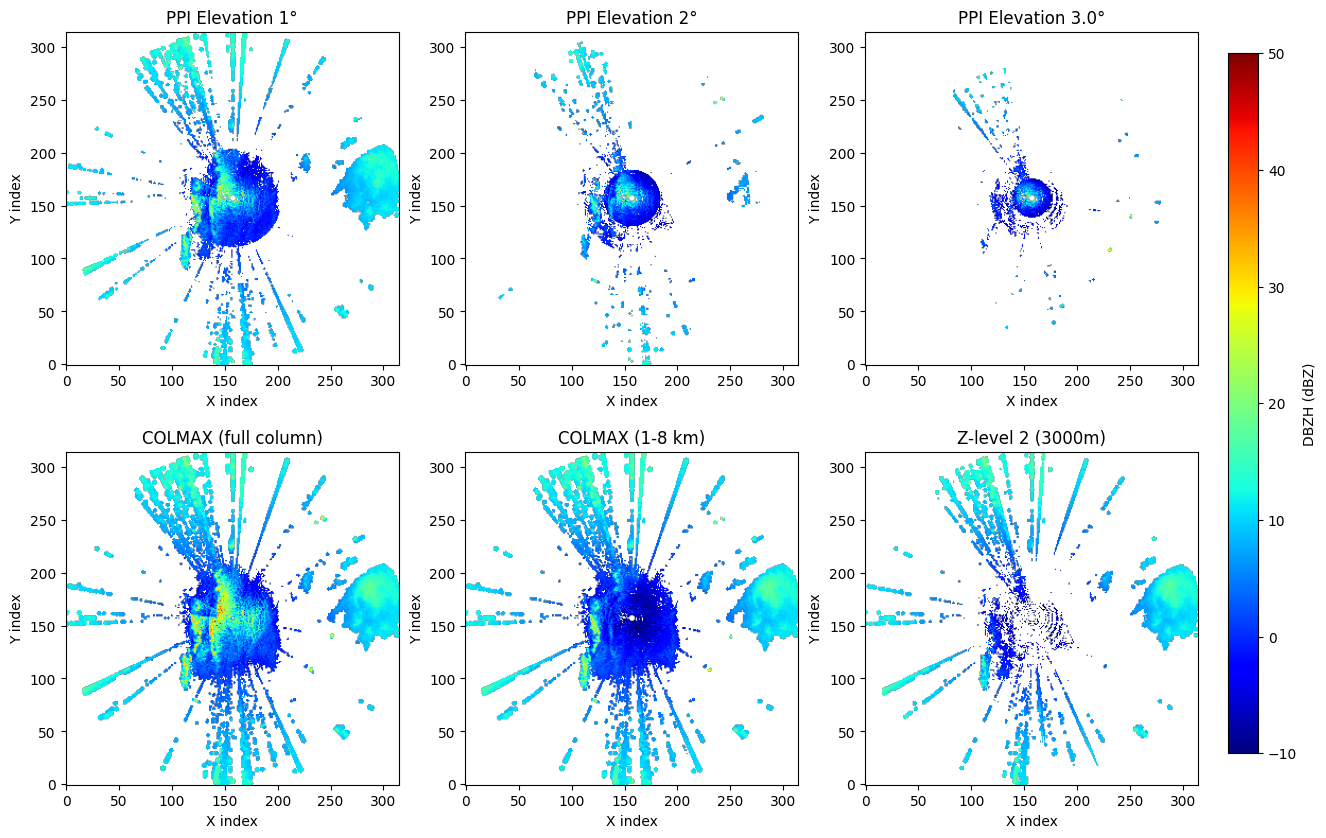

In [12]:
# Load data
# file = '/workspaces/radar-processor/data/netcdf/RMA3_0315_01_20251215T215802Z.nc'
file = '/workspaces/radar-processor/data/netcdf/RMA1_0315_01_20251208T191648Z.nc'
radar = pyart.io.read(file)
# geometry = load_geometry(geometry_dir + '/RMA1_0315_01_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1200_TOA12000_FAC022_MR200_geometry.npz')
geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz')

# Interpolate DBZH
dbzh_data = get_field_data(radar, 'DBZH')
grid_dbzh = apply_geometry(geometry, dbzh_data)

print(f"3D Grid shape: {grid_dbzh.shape}")
print(f"3D Grid DBZH range: [{np.nanmin(grid_dbzh):.2f}, {np.nanmax(grid_dbzh):.2f}]")

# --- Test Constant Elevation PPI ---
print("\n=== Constant Elevation PPI ===")
radar_alt = float(radar.altitude['data'][0])
print(f"Radar altitude: {radar_alt} m")

for elev in [1.0, 2.0, 3.0, 5.0]:
    ppi = constant_elevation_ppi(grid_dbzh, geometry, elevation_angle=elev, interpolation='linear')
    valid = np.sum(~np.isnan(ppi))
    print(f"  Elevation {elev}°: shape={ppi.shape}, valid={valid:,}, "
          f"range=[{np.nanmin(ppi):.2f}, {np.nanmax(ppi):.2f}]")

# --- Test COLMAX ---
print("\n=== Column Maximum (COLMAX) ===")

# Full column max
cmax_full = column_max(grid_dbzh)
print(f"Full COLMAX: shape={cmax_full.shape}, range=[{np.nanmin(cmax_full):.2f}, {np.nanmax(cmax_full):.2f}]")

# Column max with altitude limits
cmax_limited = column_max(grid_dbzh, z_min_alt=1000, z_max_alt=8000, geometry=geometry)
print(f"COLMAX 1-8km: shape={cmax_limited.shape}, range=[{np.nanmin(cmax_limited):.2f}, {np.nanmax(cmax_limited):.2f}]")

# --- Visualization ---
print("\n=== Visualization ===")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: PPI at different elevations
for i, elev in enumerate([1, 2, 3.0]):
    ppi = constant_elevation_ppi(grid_dbzh, geometry, elevation_angle=elev)
    im = axes[0, i].imshow(ppi, origin='lower', cmap='jet', vmin=-10, vmax=50)
    axes[0, i].set_title(f'PPI Elevation {elev}°')
    axes[0, i].set_xlabel('X index')
    axes[0, i].set_ylabel('Y index')

# Row 2: COLMAX comparisons
im1 = axes[1, 0].imshow(cmax_full, origin='lower', cmap='jet', vmin=-10, vmax=50)
axes[1, 0].set_title('COLMAX (full column)')
axes[1, 0].set_xlabel('X index')
axes[1, 0].set_ylabel('Y index')

im2 = axes[1, 1].imshow(cmax_limited, origin='lower', cmap='jet', vmin=-10, vmax=50)
axes[1, 1].set_title('COLMAX (1-8 km)')
axes[1, 1].set_xlabel('X index')
axes[1, 1].set_ylabel('Y index')

# Z-level 2 for comparison
im3 = axes[1, 2].imshow(grid_dbzh[2], origin='lower', cmap='jet', vmin=-10, vmax=50)
axes[1, 2].set_title('Z-level 2 (3000m)')
axes[1, 2].set_xlabel('X index')
axes[1, 2].set_ylabel('Y index')

# Colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im3, cax=cbar_ax, label='DBZH (dBZ)')

plt.show()

## More products

Loaded geometry: 206.3 MB in memory, toa=12000.0m
EARTH CURVATURE COMPARISON

=== Beam Height Comparison ===
Elevation 0.5°:
Range (km)   Flat (m)     Curved (m)   Diff (m)    
------------------------------------------------
50           920.3        1067.5       147.1       
100          1356.7       1945.2       588.5       
150          1793.0       3117.1       1324.1      
200          2229.4       4583.0       2353.6      
250          2665.7       6342.8       3677.0      

=== PPI Comparison at 0.5° elevation ===
Flat Earth PPI:   valid=11,441, range=[-6.64, 40.54]
Curved Earth PPI: valid=17,848, range=[-6.44, 39.97]

Beam height difference (curved - flat):
  Min: 0.0 m
  Max: 6572.9 m
  At 200km range: ~2018.6 m

=== Visualization ===


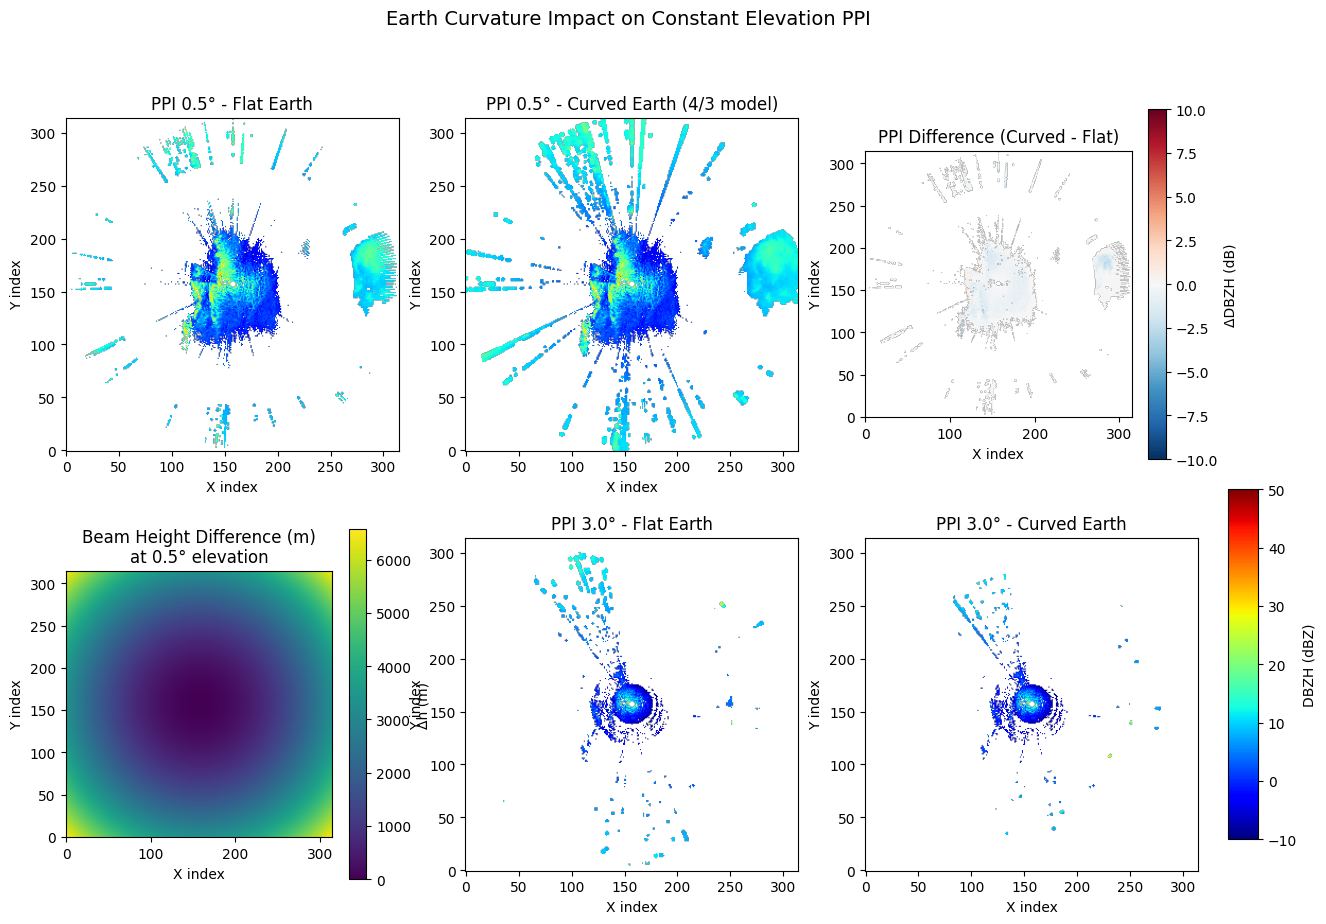


TEST COMPLETE


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/workspaces/radar-processor/src')

import pyart
from radar_grid import (
    load_geometry,
    apply_geometry,
    get_field_data,
    constant_elevation_ppi,
    get_beam_height_difference,
    compute_beam_height,
    compute_beam_height_flat,
)

# Load data
# file = '/workspaces/radar-processor/data/netcdf/RMA3_0315_01_20251215T215802Z.nc'
# radar = pyart.io.read(file)
# geometry = load_geometry('/workspaces/radar-processor/data/geometry_test.npz')
file = '/workspaces/radar-processor/data/netcdf/RMA1_0315_01_20251208T191648Z.nc'
radar = pyart.io.read(file)
# geometry = load_geometry(geometry_dir + '/RMA1_0315_01_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1200_TOA12000_FAC022_MR200_geometry.npz')
geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz')
radar_alt = float(radar.altitude['data'][0])

# Interpolate DBZH
dbzh_data = get_field_data(radar, 'DBZH')
grid_dbzh = apply_geometry(geometry, dbzh_data)

print("=" * 60)
print("EARTH CURVATURE COMPARISON")
print("=" * 60)

# --- Compare beam heights at different ranges ---
print("\n=== Beam Height Comparison ===")
print("Elevation 0.5°:")
print(f"{'Range (km)':<12} {'Flat (m)':<12} {'Curved (m)':<12} {'Diff (m)':<12}")
print("-" * 48)

distances = np.array([50, 100, 150, 200, 250]) * 1000  # km to m
for d in distances:
    h_flat = compute_beam_height_flat(d, 0.5, radar_alt)
    h_curved = compute_beam_height(d, 0.5, radar_alt)
    diff = h_curved - h_flat
    print(f"{d/1000:<12.0f} {h_flat:<12.1f} {h_curved:<12.1f} {diff:<12.1f}")

# --- Compare PPI products ---
print("\n=== PPI Comparison at 0.5° elevation ===")
ppi_flat = constant_elevation_ppi(grid_dbzh, geometry, elevation_angle=0.5, earth_curvature=False)
ppi_curved = constant_elevation_ppi(grid_dbzh, geometry, elevation_angle=0.5, earth_curvature=True)

print(f"Flat Earth PPI:   valid={np.sum(~np.isnan(ppi_flat)):,}, "
      f"range=[{np.nanmin(ppi_flat):.2f}, {np.nanmax(ppi_flat):.2f}]")
print(f"Curved Earth PPI: valid={np.sum(~np.isnan(ppi_curved)):,}, "
      f"range=[{np.nanmin(ppi_curved):.2f}, {np.nanmax(ppi_curved):.2f}]")

# Height difference map
height_diff = get_beam_height_difference(geometry, elevation_angle=1.5, 
                                          radar_altitude=radar_alt)
print(f"\nBeam height difference (curved - flat):")
print(f"  Min: {np.min(height_diff):.1f} m")
print(f"  Max: {np.max(height_diff):.1f} m")
print(f"  At 200km range: ~{height_diff[157, 280]:.1f} m")  # approximate far corner

# --- Visualization ---
print("\n=== Visualization ===")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

vmin, vmax = -10, 50

# Row 1: PPI comparison
axes[0, 0].imshow(ppi_flat, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[0, 0].set_title('PPI 0.5° - Flat Earth')
axes[0, 0].set_xlabel('X index')
axes[0, 0].set_ylabel('Y index')

axes[0, 1].imshow(ppi_curved, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[0, 1].set_title('PPI 0.5° - Curved Earth (4/3 model)')
axes[0, 1].set_xlabel('X index')
axes[0, 1].set_ylabel('Y index')

# Difference in DBZH values
ppi_diff = ppi_curved - ppi_flat
im_diff = axes[0, 2].imshow(ppi_diff, origin='lower', cmap='RdBu_r', vmin=-10, vmax=10)
axes[0, 2].set_title('PPI Difference (Curved - Flat)')
axes[0, 2].set_xlabel('X index')
axes[0, 2].set_ylabel('Y index')
plt.colorbar(im_diff, ax=axes[0, 2], label='ΔDBZH (dB)')

# Row 2: Height difference and higher elevation
im_height = axes[1, 0].imshow(height_diff, origin='lower', cmap='viridis')
axes[1, 0].set_title('Beam Height Difference (m)\nat 0.5° elevation')
axes[1, 0].set_xlabel('X index')
axes[1, 0].set_ylabel('Y index')
plt.colorbar(im_height, ax=axes[1, 0], label='Δh (m)')

# Higher elevation comparison
ppi_3deg_flat = constant_elevation_ppi(grid_dbzh, geometry, elevation_angle=3.0, earth_curvature=False)
ppi_3deg_curved = constant_elevation_ppi(grid_dbzh, geometry, elevation_angle=3.0, earth_curvature=True)

axes[1, 1].imshow(ppi_3deg_flat, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[1, 1].set_title('PPI 3.0° - Flat Earth')
axes[1, 1].set_xlabel('X index')
axes[1, 1].set_ylabel('Y index')

im = axes[1, 2].imshow(ppi_3deg_curved, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[1, 2].set_title('PPI 3.0° - Curved Earth')
axes[1, 2].set_xlabel('X index')
axes[1, 2].set_ylabel('Y index')

# Colorbar for DBZH
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.35])
fig.colorbar(im, cax=cbar_ax, label='DBZH (dBZ)')

plt.suptitle('Earth Curvature Impact on Constant Elevation PPI', fontsize=14, y=0.98)
plt.show()

print("\n" + "=" * 60)
print("TEST COMPLETE")
print("=" * 60)

## Filtered products

Loaded geometry: 206.3 MB in memory, toa=12000.0m
PRODUCTS WITH FILTERS TEST

=== Unfiltered ===
3D Grid valid points: 73,788
DBZH range: [-18.90, 44.91]

=== With Filter ===
GateFilter Summary:
  Total gates: 3,520,800
  Excluded: 2,535,602 (72.0%)
  Included: 985,198 (28.0%)
  Filters applied (2):
    - DBZH < 5
    - range > 200000m

3D Grid valid points: 34,524
DBZH range: [5.00, 44.91]

=== Constant Elevation PPI (1.5°) ===
Unfiltered PPI: valid=9,460, range=[-7.27, 34.26]
Filtered PPI:   valid=3,724, range=[5.03, 32.11]

=== COLMAX ===
Unfiltered COLMAX: valid=23,552, range=[-10.56, 44.91]
Filtered COLMAX:   valid=13,086, range=[5.00, 44.91]
Filtered COLMAX (2-10km): valid=8,411, range=[5.00, 28.15]

=== Visualization ===


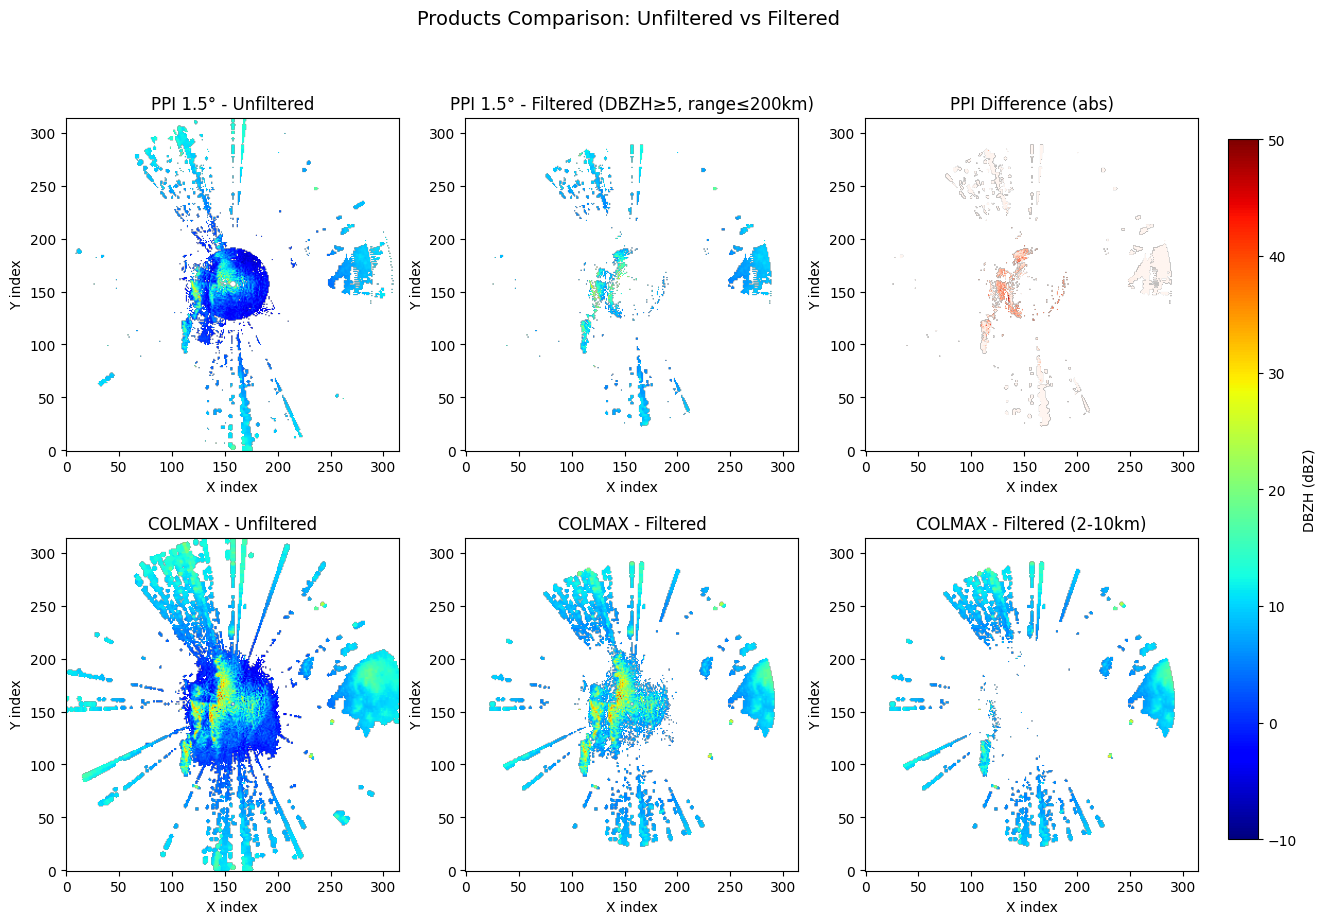


TEST COMPLETE


In [15]:
# Load data
# file = '/workspaces/radar-processor/data/netcdf/RMA3_0315_01_20251215T215802Z.nc'
file = '/workspaces/radar-processor/data/netcdf/RMA1_0315_01_20251208T191648Z.nc'
radar = pyart.io.read(file)
# geometry = load_geometry(geometry_dir + '/RMA1_0315_01_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1200_TOA12000_FAC022_MR200_geometry.npz')
geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz')
radar_alt = float(radar.altitude['data'][0])

print("=" * 60)
print("PRODUCTS WITH FILTERS TEST")
print("=" * 60)

# --- Unfiltered Grid ---
print("\n=== Unfiltered ===")
dbzh_data = get_field_data(radar, 'DBZH')
grid_unfiltered = apply_geometry(geometry, dbzh_data)
print(f"3D Grid valid points: {np.sum(~np.isnan(grid_unfiltered)):,}")
print(f"DBZH range: [{np.nanmin(grid_unfiltered):.2f}, {np.nanmax(grid_unfiltered):.2f}]")

# --- Filtered Grid ---
print("\n=== With Filter ===")

# Create filter: keep only significant reflectivity
gf = (GateFilter(radar)
      .exclude_below('DBZH', 5)          # Exclude weak echoes < 5 dBZ
      .exclude_above_range(200000))      # Exclude far range > 200km

print(gf.summary())

# Get filtered data
# dbzh_data_filt, dbzh_mask_filt = create_mask_from_filter(radar, 'DBZH', gf)
grid_filtered = apply_geometry(geometry, dbzh_data, additional_filters=[gf])
print(f"\n3D Grid valid points: {np.sum(~np.isnan(grid_filtered)):,}")
print(f"DBZH range: [{np.nanmin(grid_filtered):.2f}, {np.nanmax(grid_filtered):.2f}]")

# --- Products Comparison ---
print("\n=== Constant Elevation PPI (1.5°) ===")
ppi_unfiltered = constant_elevation_ppi(grid_unfiltered, geometry, 
                                         elevation_angle=1.5)
ppi_filtered = constant_elevation_ppi(grid_filtered, geometry, 
                                       elevation_angle=1.5)

print(f"Unfiltered PPI: valid={np.sum(~np.isnan(ppi_unfiltered)):,}, "
      f"range=[{np.nanmin(ppi_unfiltered):.2f}, {np.nanmax(ppi_unfiltered):.2f}]")
print(f"Filtered PPI:   valid={np.sum(~np.isnan(ppi_filtered)):,}, "
      f"range=[{np.nanmin(ppi_filtered):.2f}, {np.nanmax(ppi_filtered):.2f}]")

print("\n=== COLMAX ===")
cmax_unfiltered = column_max(grid_unfiltered)
cmax_filtered = column_max(grid_filtered)

print(f"Unfiltered COLMAX: valid={np.sum(~np.isnan(cmax_unfiltered)):,}, "
      f"range=[{np.nanmin(cmax_unfiltered):.2f}, {np.nanmax(cmax_unfiltered):.2f}]")
print(f"Filtered COLMAX:   valid={np.sum(~np.isnan(cmax_filtered)):,}, "
      f"range=[{np.nanmin(cmax_filtered):.2f}, {np.nanmax(cmax_filtered):.2f}]")

# COLMAX with altitude limits
cmax_filt_alt = column_max(grid_filtered, z_min_alt=2000, z_max_alt=10000, geometry=geometry)
print(f"Filtered COLMAX (2-10km): valid={np.sum(~np.isnan(cmax_filt_alt)):,}, "
      f"range=[{np.nanmin(cmax_filt_alt):.2f}, {np.nanmax(cmax_filt_alt):.2f}]")

# --- Visualization ---
print("\n=== Visualization ===")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

vmin, vmax = -10, 50

# Row 1: PPI comparison
axes[0, 0].imshow(ppi_unfiltered, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[0, 0].set_title('PPI 1.5° - Unfiltered')
axes[0, 0].set_xlabel('X index')
axes[0, 0].set_ylabel('Y index')

axes[0, 1].imshow(ppi_filtered, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[0, 1].set_title('PPI 1.5° - Filtered (DBZH≥5, range≤200km)')
axes[0, 1].set_xlabel('X index')
axes[0, 1].set_ylabel('Y index')

# Difference
diff_ppi = ppi_unfiltered - ppi_filtered
axes[0, 2].imshow(np.abs(diff_ppi), origin='lower', cmap='Reds', vmin=0, vmax=20)
axes[0, 2].set_title('PPI Difference (abs)')
axes[0, 2].set_xlabel('X index')
axes[0, 2].set_ylabel('Y index')

# Row 2: COLMAX comparison
axes[1, 0].imshow(cmax_unfiltered, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[1, 0].set_title('COLMAX - Unfiltered')
axes[1, 0].set_xlabel('X index')
axes[1, 0].set_ylabel('Y index')

axes[1, 1].imshow(cmax_filtered, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[1, 1].set_title('COLMAX - Filtered')
axes[1, 1].set_xlabel('X index')
axes[1, 1].set_ylabel('Y index')

im = axes[1, 2].imshow(cmax_filt_alt, origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[1, 2].set_title('COLMAX - Filtered (2-10km)')
axes[1, 2].set_xlabel('X index')
axes[1, 2].set_ylabel('Y index')

# Colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='DBZH (dBZ)')

plt.suptitle('Products Comparison: Unfiltered vs Filtered', fontsize=14, y=0.98)
plt.show()

print("\n" + "=" * 60)
print("TEST COMPLETE")
print("=" * 60)

Loaded geometry: 206.3 MB in memory, toa=12000.0m
=== Understanding the PPI Issue ===

Radar altitude: 484.0 m
Grid Z limits: (np.float64(0.0), np.float64(12000.0))
Grid shape: (np.int64(9), np.int64(315), np.int64(315))

Grid Z levels: [    0.  1500.  3000.  4500.  6000.  7500.  9000. 10500. 12000.]

=== Beam Height at 0.5° Elevation ===
Distance (km)   Beam Height (m)    Closest Z-level
--------------------------------------------------
0               484.0              0              
5               529.1              0              
10              577.2              0              
20              682.1              0              
50              1067.5             1500           
100             1945.2             1500           
150             3117.1             3000           
200             4583.0             4500           

=== Data Availability per Z-level ===
  Z=     0m (level 0):  7,535 valid points (7.6%)
  Z=  1500m (level 1): 15,626 valid points (15.7%)
  Z=  300

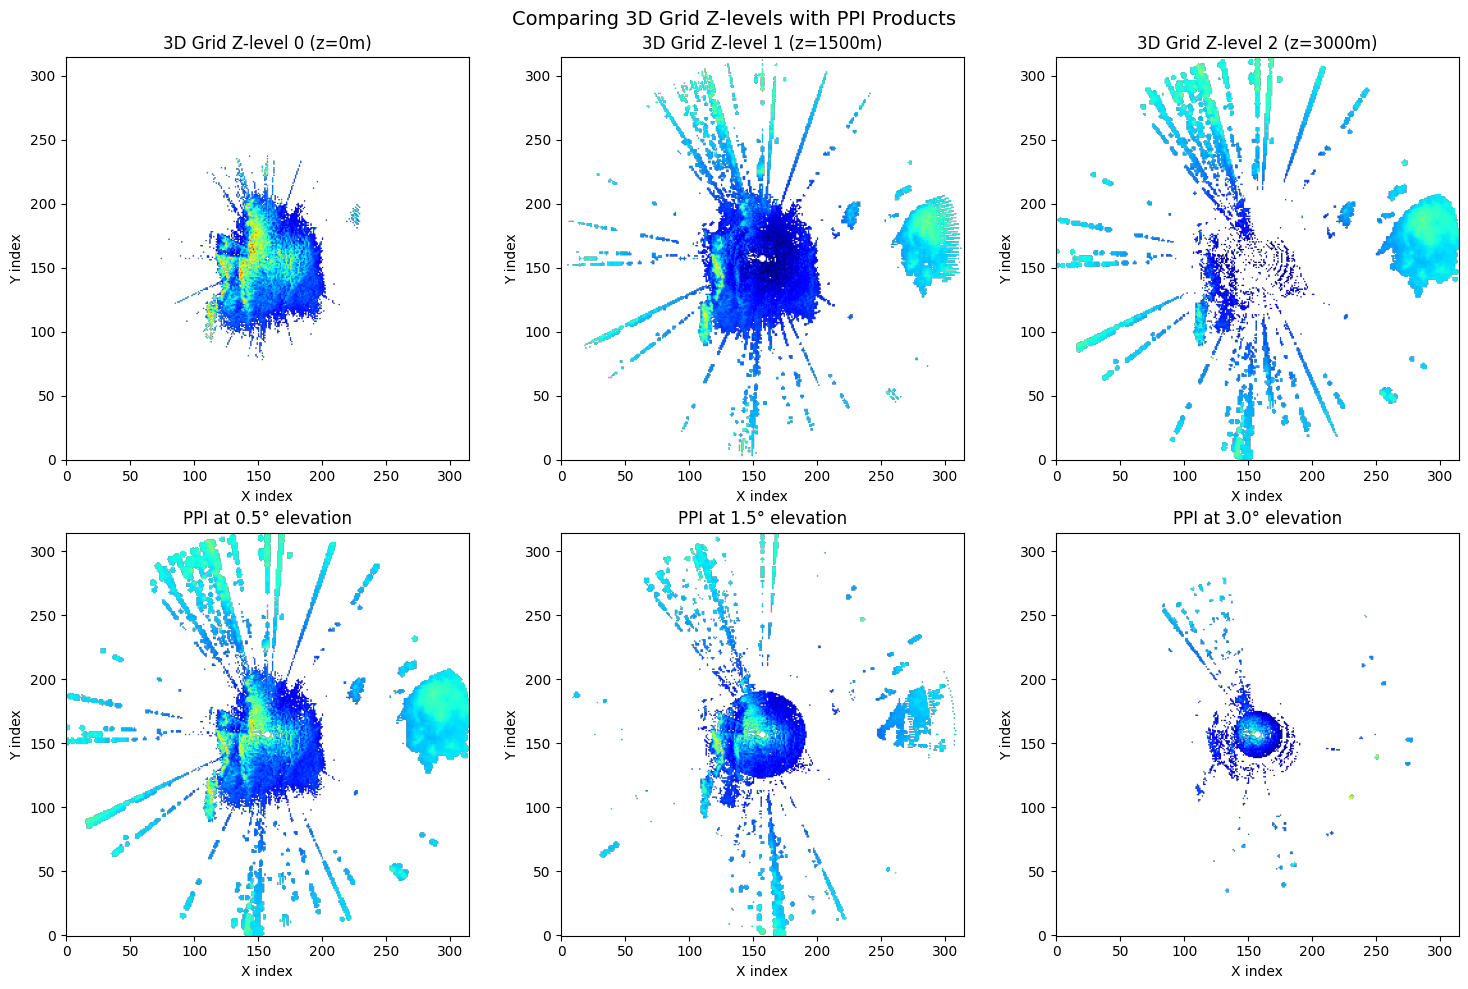


=== Beam Height Map at 0.5° ===
Beam height at 0.5° elevation:
  At center (0 km):   484.0 m
  At 50 km range:     1067.5 m
  At 100 km range:    1945.2 m
  Min grid Z:         0.0 m
  First Z-level:      0.0 m
  Second Z-level:     1500.0 m


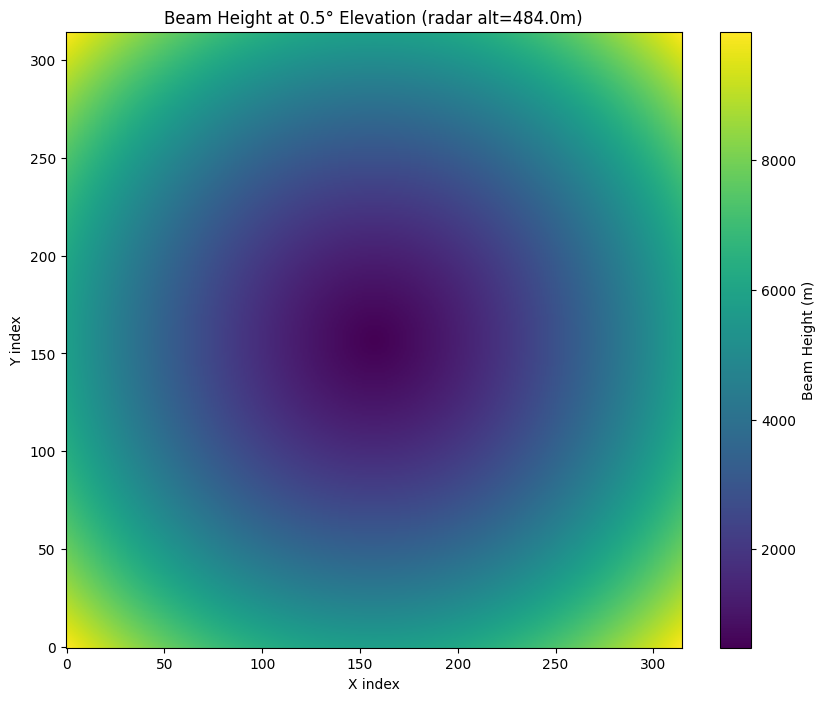

In [16]:
# Load data
# file = '/workspaces/radar-processor/data/netcdf/RMA3_0315_01_20251215T215802Z.nc'
file = '/workspaces/radar-processor/data/netcdf/RMA1_0315_01_20251208T191648Z.nc'
radar = pyart.io.read(file)
# geometry = load_geometry(geometry_dir + '/RMA1_0315_01_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_geometry.npz')
# geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1200_TOA12000_FAC022_MR200_geometry.npz')
geometry = load_geometry(f'{geometry_dir}/RMA1_0315_01_RES1500_TOA12000_FAC017_MR250_geometry.npz')

radar_lat = float(radar.latitude['data'][0])
radar_lon = float(radar.longitude['data'][0])
radar_alt = float(radar.altitude['data'][0])

print("=== Understanding the PPI Issue ===")
print(f"\nRadar altitude: {radar_alt} m")
print(f"Grid Z limits: {geometry.grid_limits[0]}")
print(f"Grid shape: {geometry.grid_shape}")

# Z coordinates of the grid
nz = geometry.grid_shape[0]
z_min, z_max = geometry.grid_limits[0]
z_coords = np.linspace(z_min, z_max, nz)
print(f"\nGrid Z levels: {z_coords}")

# Let's see what beam heights we get at various distances for low elevation
print("\n=== Beam Height at 0.5° Elevation ===")
print(f"{'Distance (km)':<15} {'Beam Height (m)':<18} {'Closest Z-level':<15}")
print("-" * 50)

distances = np.array([0, 5, 10, 20, 50, 100, 150, 200]) * 1000

for d in distances:
    h = compute_beam_height(np.array([d]), 0.5, radar_alt)[0]
    closest_z_idx = np.argmin(np.abs(z_coords - h))
    closest_z = z_coords[closest_z_idx]
    print(f"{d/1000:<15.0f} {h:<18.1f} {closest_z:<15.0f}")

# Now let's check how much data is in each z-level of the 3D grid
print("\n=== Data Availability per Z-level ===")
dbzh_data = get_field_data(radar, 'DBZH')
grid_dbzh = apply_geometry(geometry, dbzh_data)

for i, z in enumerate(z_coords):
    valid_count = np.sum(~np.isnan(grid_dbzh[i]))
    total_count = grid_dbzh[i].size
    pct = 100 * valid_count / total_count
    print(f"  Z={z:6.0f}m (level {i}): {valid_count:6,} valid points ({pct:.1f}%)")

# Visualize what's happening
print("\n=== Visualization ===")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Low Z-levels of the 3D grid
for i in range(3):
    axes[0, i].imshow(grid_dbzh[i], origin='lower', cmap='jet', vmin=-10, vmax=50)
    axes[0, i].set_title(f'3D Grid Z-level {i} (z={z_coords[i]:.0f}m)')
    axes[0, i].set_xlabel('X index')
    axes[0, i].set_ylabel('Y index')

# Row 2: PPIs at low elevations
for i, elev in enumerate([0.5, 1.5, 3.0]):
    ppi = constant_elevation_ppi(grid_dbzh, geometry, elevation_angle=elev, earth_curvature=True)
    axes[1, i].imshow(ppi, origin='lower', cmap='jet', vmin=-10, vmax=50)
    axes[1, i].set_title(f'PPI at {elev}° elevation')
    axes[1, i].set_xlabel('X index')
    axes[1, i].set_ylabel('Y index')

plt.suptitle('Comparing 3D Grid Z-levels with PPI Products', fontsize=14)
plt.tight_layout()
plt.show()

# Show beam height across the grid for 0.5° elevation
print("\n=== Beam Height Map at 0.5° ===")
y_min, y_max = geometry.grid_limits[1]
x_min, x_max = geometry.grid_limits[2]
ny, nx = geometry.grid_shape[1], geometry.grid_shape[2]

y_coords_grid = np.linspace(y_min, y_max, ny)
x_coords_grid = np.linspace(x_min, x_max, nx)
yy, xx = np.meshgrid(y_coords_grid, x_coords_grid, indexing='ij')
horizontal_dist = np.sqrt(xx**2 + yy**2)

beam_height_05 = compute_beam_height(horizontal_dist, 0.5, radar_alt)

print(f"Beam height at 0.5° elevation:")
print(f"  At center (0 km):   {beam_height_05[ny//2, nx//2]:.1f} m")
print(f"  At 50 km range:     {compute_beam_height(np.array([50000]), 0.5, radar_alt)[0]:.1f} m")
print(f"  At 100 km range:    {compute_beam_height(np.array([100000]), 0.5, radar_alt)[0]:.1f} m")
print(f"  Min grid Z:         {z_min} m")
print(f"  First Z-level:      {z_coords[0]} m")
print(f"  Second Z-level:     {z_coords[1]} m")

fig2, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(beam_height_05, origin='lower', cmap='viridis')
ax.set_title(f'Beam Height at 0.5° Elevation (radar alt={radar_alt}m)')
ax.set_xlabel('X index')
ax.set_ylabel('Y index')
plt.colorbar(im, ax=ax, label='Beam Height (m)')
plt.show()